# 03 – PCA and Heatmaps (CD44_high vs CD44_low)

📓 This notebook:

- Loads the processed count matrix, metadata, and DESeq2 results
- Performs PCA on the top 1000 most variable genes
- Visualizes sample separation by CD44 phenotype
- Produces two heatmaps:
    - A standard heatmap of the top 50 DE genes
    - A clustered heatmap (z-scored expression + hierarchical clustering)

These visualizations help assess transcriptomic differences between
CD44_high and CD44_low subpopulations in the GSE113660 dataset.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---------------------------------------------------------------------
# Load processed data and DESeq2 results
# ---------------------------------------------------------------------
BASE_DIR = Path("..").resolve()
DATA_PROCESSED = BASE_DIR / "data" / "processed"
RESULTS_DIR = BASE_DIR / "results"
FIG_DIR = BASE_DIR / "figures"

counts = pd.read_csv(DATA_PROCESSED / "GSE113660_counts.csv", index_col=0)
metadata = pd.read_csv(DATA_PROCESSED / "GSE113660_metadata.csv")
res_df = pd.read_csv(RESULTS_DIR / "GSE113660_deseq2_results.csv", index_col=0)

print(counts.shape)
print(metadata.shape)
print(res_df.shape)
metadata.head()


(33572, 9)
(9, 2)
(22115, 6)


,sample,condition
0,SJRHB046412_C1,unsorted
1,SJRHB046412_C2,CD44_high
2,SJRHB046412_C3,CD44_low
3,SJRHB046412_C4,CD44_low
4,SJRHB046412_C5,CD44_low


(33572, 6)
                condition
SJRHB046412_C2  CD44_high
SJRHB046412_C3   CD44_low
SJRHB046412_C4   CD44_low
SJRHB046412_C5   CD44_low
SJRHB046412_C6  CD44_high
SJRHB046412_C7  CD44_high


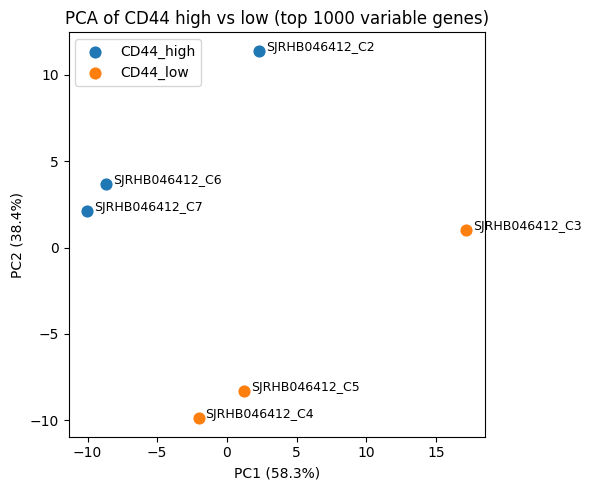

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------------------------
# Prepare metadata and subset to CD44_high / CD44_low samples
# ---------------------------------------------------------------------

# Set sample column as index and align with counts columns
metadata = metadata.set_index("sample")
metadata = metadata.loc[counts.columns]   # ترتیب metadata دقیقا مثل ستون‌های counts

# Keep only CD44_high and CD44_low samples
mask = metadata["condition"].isin(["CD44_high", "CD44_low"])
counts_sub = counts.loc[:, mask.values]   # boolean index applied to columns
metadata_sub = metadata.loc[mask.values]

print(counts_sub.shape)
print(metadata_sub)

# ---------------------------------------------------------------------
# Select top 1000 most variable genes for PCA
# ---------------------------------------------------------------------
gene_var = counts_sub.var(axis=1)
top_genes = gene_var.sort_values(ascending=False).head(1000).index
counts_top = counts_sub.loc[top_genes]

# Log-transform and compute PCA
log_counts = np.log1p(counts_top.T)

pca = PCA(n_components=2)
components = pca.fit_transform(log_counts)

# ---------------------------------------------------------------------
# PCA plot
# ---------------------------------------------------------------------
plt.figure(figsize=(6,5))
for cond in metadata_sub["condition"].unique():
    mask_c = metadata_sub["condition"] == cond
    plt.scatter(
        components[mask_c, 0],
        components[mask_c, 1],
        label=cond,
        s=60
    )

# Annotate sample names
for i, sample in enumerate(metadata_sub.index):
    plt.text(components[i,0]+0.5, components[i,1], sample, fontsize=9)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of CD44 high vs low (top 1000 variable genes)")
plt.legend()
plt.tight_layout()
plt.show()


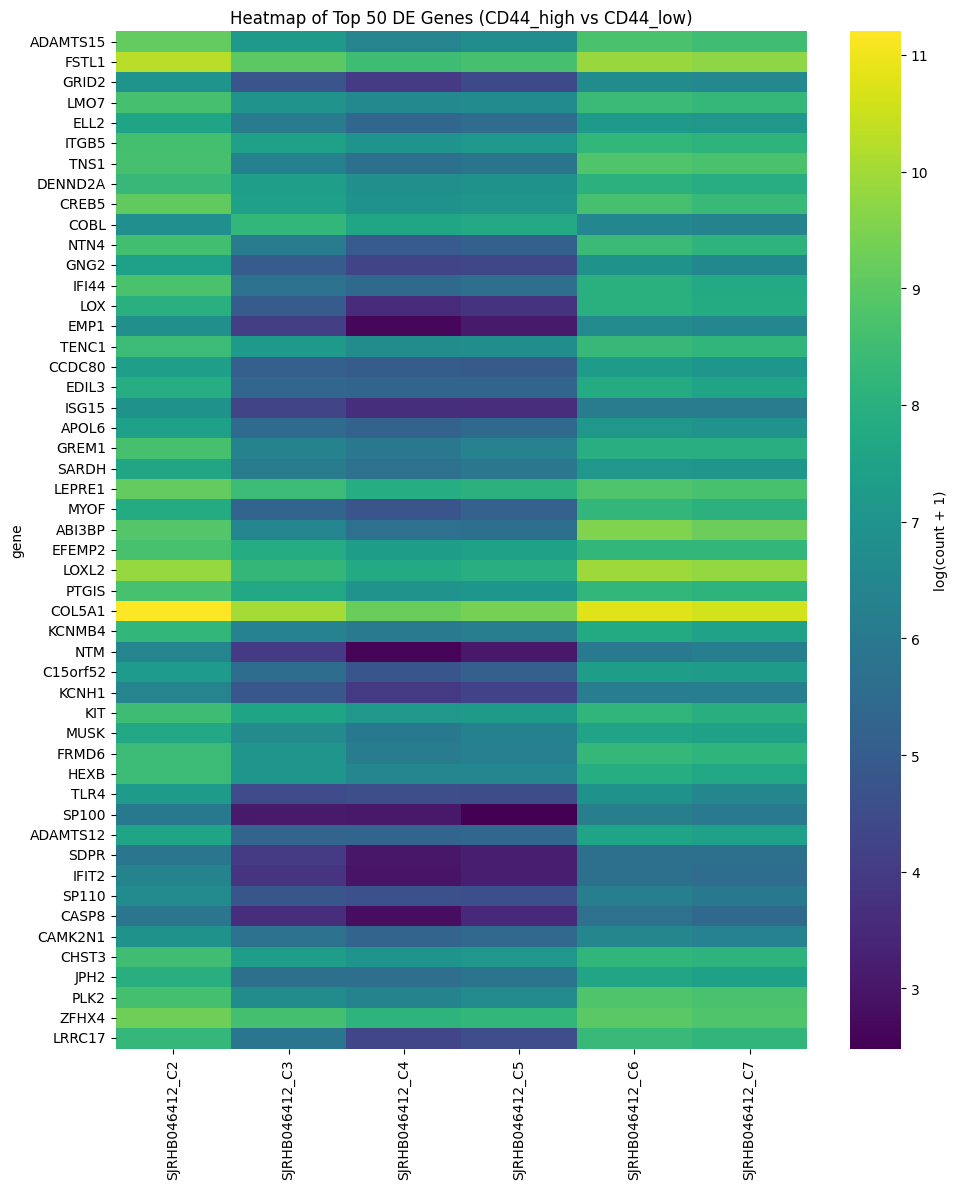

PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/figures/heatmap_top50_DE_genes.png')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Prepare DESeq2 results and select top 50 DE genes
# ---------------------------------------------------------------------
df_res = res_df.copy()
df_res = df_res.dropna(subset=["padj"])
df_res = df_res.sort_values("padj")  

top50_genes = df_res.head(50).index.tolist()

# Subset counts and metadata to high/low samples
mask = metadata["condition"].isin(["CD44_high", "CD44_low"])
counts_sub = counts.loc[top50_genes, metadata["condition"].isin(["CD44_high", "CD44_low"])]
metadata_sub = metadata.loc[mask]

# Log-transform for visualization
log_mat = np.log1p(counts_sub)

# ---------------------------------------------------------------------
# Heatmap (no clustering)
# ---------------------------------------------------------------------
plt.figure(figsize=(10, 12))
sns.heatmap(
    log_mat,
    cmap="viridis",
    yticklabels=True,
    xticklabels=metadata_sub.index,
    cbar_kws={"label": "log(count + 1)"}
)

plt.title("Heatmap of Top 50 DE Genes (CD44_high vs CD44_low)")
plt.tight_layout()

heat_path = FIG_DIR / "heatmap_top50_DE_genes.png"
plt.savefig(heat_path, dpi=300)
plt.show()

heat_path


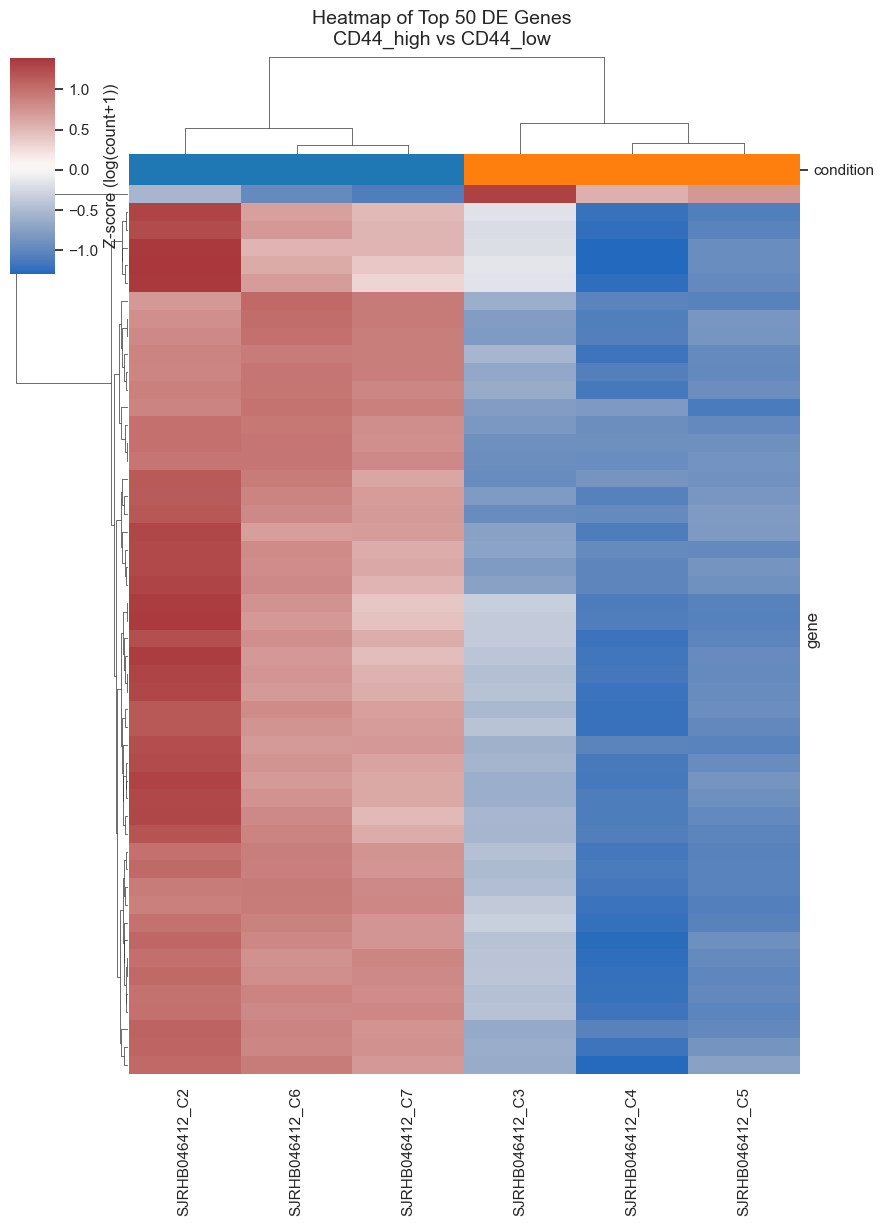

PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/figures/clustermap_top50_DE_genes.png')

In [4]:
sns.set_theme(style="white")

# ---------------------------------------------------------------------
# Clustered heatmap with z-scored log-transformed counts
# ---------------------------------------------------------------------
mask = metadata["condition"].isin(["CD44_high", "CD44_low"])
counts_sub = counts.loc[:, mask]
metadata_sub = metadata.loc[mask]
metadata_sub = metadata_sub.loc[counts_sub.columns]  # align

df_res = res_df.copy().dropna(subset=["padj"]).sort_values("padj")
top50_genes = df_res.head(50).index.tolist()

counts_top50 = counts_sub.loc[top50_genes]
log_mat = np.log1p(counts_top50)

# Z-score per gene (row-wise)
log_z = log_mat.sub(log_mat.mean(axis=1), axis=0)
log_z = log_z.div(log_mat.std(axis=1) + 1e-8, axis=0)

# Column colors by condition
lut = {"CD44_high": "#1f77b4", "CD44_low": "#ff7f0e"}
col_colors = metadata_sub["condition"].map(lut)

# ---------------------------------------------------------------------
# Create clustermap
# ---------------------------------------------------------------------
g = sns.clustermap(
    log_z,
    cmap="vlag",
    col_colors=col_colors,
    xticklabels=metadata_sub.index,
    yticklabels=False,
    figsize=(9, 12),
    dendrogram_ratio=(0.15, 0.1),
    cbar_kws={"label": "Z-score (log(count+1))"}
)

g.fig.suptitle(
    "Heatmap of Top 50 DE Genes\nCD44_high vs CD44_low",
    fontsize=14,
    y=1.02
)

cluster_path = FIG_DIR / "clustermap_top50_DE_genes.png"
g.savefig(cluster_path, dpi=300)
plt.show()

cluster_path
